In [1]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import math

In [99]:
# use ggplot style
plt.style.use('ggplot')

In [100]:
# -----------------------------
# exponentail nature of the problem
# -----------------------------

(0.0, 2.0)

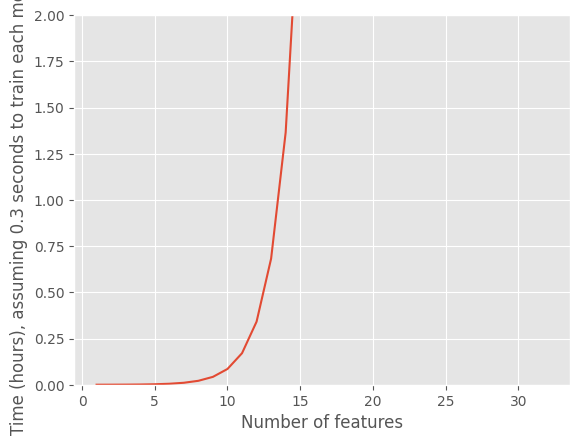

In [101]:
len_choose_2 = lambda n, k: math.factorial(n) / (math.factorial(k) * math.factorial(n - k))
num = 32
number_of_choices = [sum([len_choose_2(n,i) for i in range(1,n+1)])*0.3/3600 for n in range(1, num+1)]
plt.plot(range(1, num+1), number_of_choices)
plt.xlabel("Number of features")
plt.ylabel("Time (hours), assuming 0.3 seconds to train each model")
plt.ylim(0,2)

In [102]:
torch.manual_seed(0)

In [103]:
class Model():
    def __init__(self, mtype, n_input):
        if mtype == "sigmoid":
            self.sequential = torch.nn.Sequential(nn.Linear(n_input, 1), nn.Sigmoid())
        elif mtype == "linear":
            self.sequential = torch.nn.Sequential(nn.Linear(n_input, 1))
        
    def forward(self, x):
        return self.sequential(x)
    
    def train(self,X_train,y_train,lr=0.01,epochs=1000):
        loss_fn = nn.MSELoss()
        # learning rate decay
        optimizer = optim.SGD(self.sequential.parameters(),lr=lr)
        self.losses = []
        for i in range(epochs):
            y_h = self.forward(X_train)
            loss = loss_fn(y_h, y_train)
            self.losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    def calculate_R2(self, X_test, y_test):
        y_h = self.forward(X_test)
        return 1 - torch.sum((y_test - y_h)**2)/torch.sum((y_test - torch.mean(y_test))**2)

In [104]:
def choose_k_c_times(a,k,c):
    c = min(c, int(math.factorial(len(a))/(math.factorial(len(a)-k)*math.factorial(k))))
    chosen = []
    for i in range(c):
        while True:
            choice = tuple(np.random.choice(a, k, replace=False))
            if choice not in chosen: # here we should check other permutations of choice!!!
                chosen.append(choice)
                break
            if len(chosen) >= c:
                break
    return chosen

In [ ]:
vdecomp

In [105]:
def generate_data(n_input, m):
    X = np.random.normal(0, 3, (m, n_input)) # Sample random integers from 0 to 10 from a Gaussian distribution into an array of shape (m, n_input)
    # y = 2 * x_0 + 0.5 * x_1 + 0.5 * x_2 + 1 * x_3 + 2 * x_4 + 4 * x_5
    y = 2 * X[:, 0] + 0.5 * X[:, 1]+ 0.5 *X[:, 2] + 1 * X[:, 3] + 2 * bX[:, 4]*X[:, 5]
    y = y.reshape(-1, 1) # reshape y to be a column vector

    # add noise to X and y
    X += np.random.normal(0, 0.1, X.shape)
    y += np.random.normal(0, 0.1, y.shape)

    # # # normalize y and X between 0 and 1
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    #X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0)) # converges faster when X is normalized(for some reason)
    # divide X and y into training and test sets
    X_train, X_test, y_train, y_test = X[:800], X[800:], y[:800], y[800:]
    return torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

tensor(0.1487, grad_fn=<RsubBackward1>)


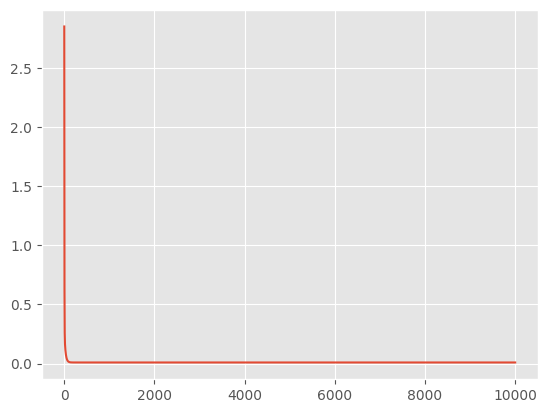

In [106]:
# TODO: sample the data l times and plot a histogram of the R2 values
X_train, X_test, y_train, y_test = generate_data(6, 1000)
model = Model("linear", 6)
model.train(X_train, y_train, lr=0.01, epochs=10000)
print(model.calculate_R2(X_test, y_test))
plt.plot(model.losses)

In [107]:
# -----------------------------
# Final code
# -----------------------------

# generate data
n_input = 6
X_train, X_test, y_train, y_test = generate_data(n_input, 1000)

# for each k, we will train 10 models or all possible combinations of k features if that is less than 10
r2_per_k_s = []
r2_per_k_l = []
for k in range(1, n_input):
    cols_to_drop = choose_k_c_times(range(n_input), k, 15)
    r2s = []
    r2l = []
    for cols in cols_to_drop:
        # truncate X_train and X_test
        X_train_tr = X_train[:, [i for i in range(n_input) if i not in cols]]
        X_test_tr = X_test[:, [i for i in range(n_input) if i not in cols]]

        # train models
        model_sigmoid = Model("sigmoid", n_input - k)
        model_linear = Model("linear", n_input - k)
        model_sigmoid.train(X_train_tr, y_train, lr=0.01, epochs=10000)
        model_linear.train(X_train_tr, y_train)
        # calculate R2
        r2_sigmoid = model_sigmoid.calculate_R2(X_test_tr, y_test).item()
        r2_linear = model_linear.calculate_R2(X_test_tr, y_test).item()
        r2s.append(r2_sigmoid)
        r2l.append(r2_linear)
    r2_per_k_s.append(np.mean(np.array(r2s)))
    r2_per_k_l.append(np.mean(np.array(r2l)))
        

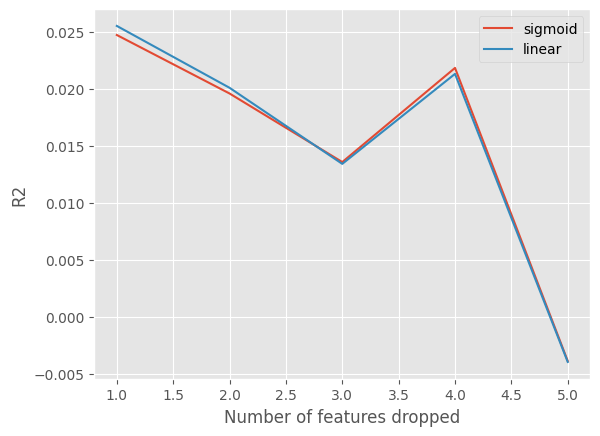

In [108]:
plt.plot(range(1, n_input), r2_per_k_s, label="sigmoid")
plt.plot(range(1, n_input), r2_per_k_l, label="linear")
plt.xlabel("Number of features dropped")
plt.ylabel("R2")
plt.legend()